In [27]:
from model.yolo import MiniYoloMultiScale
from model.classifer import SimpleCNN, SimpleMLP

In [37]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
from torchvision import transforms
import torchvision
from utils.yoloinfer import decode_predictions

# Define anchors (from yolo.ipynb)
anchors = [
    (0.11500,0.51250),
    (0.11000,0.42500),
    (0.12000,0.42500),
    (0.12000,0.53750),
    (0.13000,0.55000),
    (0.14500,0.60000),
    (0.15000,0.8000),
    (0.17000,0.8000),
]

def load_models():
    """Load both YOLO and classifier models"""
    # Load YOLO model
    yolo_model = MiniYoloMultiScale(in_chan=1, num_class=10, anchors=len(anchors))
    yolo_checkpoint = torch.load(r'checkpoints\mini_yolo_multiscale_epoch_61.pth', map_location='cpu')
    yolo_model.load_state_dict(yolo_checkpoint['model_state_dict'])
    yolo_model.eval()
    
    # Load classifier model - Updated to use your trained model
    classifier_model = SimpleMLP(num_classes=10)
    classifier_checkpoint = torch.load(r'checkpoints\classifiermlp_epoch_16.pth', map_location='cpu', weights_only=False)
    classifier_model.load_state_dict(classifier_checkpoint['model_state_dict'])
    classifier_model.eval()
    
    print(f"Loaded classifier with validation accuracy: {classifier_checkpoint.get('best_val_acc', 'N/A'):.2f}%")
    
    return yolo_model, classifier_model
def preprocess_image_for_yolo(image_path, img_size=(80, 200)):
    """Preprocess image for YOLO inference - matching yolo.ipynb format"""
    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    
    # Use the same transform as in yolo.ipynb
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.Grayscale(num_output_channels=1),  # True grayscale
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ])
    
    img_tensor = transform(image).unsqueeze(0)
    return img_tensor, original_size

def extract_character_boxes(image_path, yolo_model, conf_threshold=0.45, iou_threshold=0.35):
    """Extract character bounding boxes using YOLO - select top 5 by confidence after NMS"""
    img_tensor, original_size = preprocess_image_for_yolo(image_path)
    
    with torch.no_grad():
        outputs = yolo_model(img_tensor)
    
    # Debug: Print output structure
    print(f"YOLO output type: {type(outputs)}")
    if isinstance(outputs, (tuple, list)):
        print(f"Number of scales: {len(outputs)}")
        for i, out in enumerate(outputs):
            print(f"Scale {i} shape: {out.shape}")
    else:
        print(f"Single output shape: {outputs.shape}")
    
    # Use your decode_predictions with correct img_size format (W, H)
    IMG_SIZE = (200, 80)  # (W, H) format as expected by decode_predictions
    
    # Decode predictions using your existing function
    decoded_results = decode_predictions(
        outputs, IMG_SIZE, anchors,
        conf_thresh=conf_threshold,
        iou_thresh=iou_threshold
    )
    
    # Get results for first batch (batch index 0)
    if not decoded_results or len(decoded_results) == 0:
        print("No detections from decode_predictions")
        return []
    
    boxes, scores, sel_idx = decoded_results[0]
    
    if boxes.numel() == 0:
        print("Empty boxes tensor")
        return []
    
    print(f"Decoded boxes shape: {boxes.shape}")
    print(f"Decoded scores shape: {scores.shape}")
    print(f"Selected indices shape: {sel_idx.shape}")
    
    # Get predicted classes for each box using sel_idx
    pred_classes = []
    
    if isinstance(outputs, (tuple, list)):
        # Multi-scale: use first scale for class prediction (largest resolution)
        cls_logits = outputs[0][..., 5:][0]  # (A,H,W,num_class)
        for idx in sel_idx:
            a, y, x = idx.tolist()
            # Ensure indices are within bounds for first scale
            H_scale, W_scale = cls_logits.shape[1], cls_logits.shape[2]
            y_bounded = min(y, H_scale-1)
            x_bounded = min(x, W_scale-1)
            class_prob = cls_logits[a, y_bounded, x_bounded].softmax(dim=-1)
            pred_class = class_prob.argmax().item()
            pred_classes.append(pred_class)
    else:
        # Single scale
        cls_logits = outputs[..., 5:][0]  # (A,H,W,num_class)
        for idx in sel_idx:
            a, y, x = idx.tolist()
            class_prob = cls_logits[a, y, x].softmax(dim=-1)
            pred_class = class_prob.argmax().item()
            pred_classes.append(pred_class)
    
    # Boxes are already in pixel coordinates, but we need to ensure they're in original image coordinates
    # The decode_predictions function converts to pixel coords using W_img, H_img (200, 80)
    # We need to scale to original image size
    orig_w, orig_h = original_size
    scale_x = orig_w / 200  # Scale from 200 to original width
    scale_y = orig_h / 80   # Scale from 80 to original height
    
    print(f"Original size: {original_size}")
    print(f"Target size: (200, 80)")
    print(f"Scale factors: x={scale_x:.3f}, y={scale_y:.3f}")
    
    boxes_list = []
    boxes_np = boxes.cpu().numpy()
    
    for i, (x1, y1, x2, y2) in enumerate(boxes_np):
        print(f"Decoded box {i}: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")
        
        # Scale to original image size
        x1_orig = int(x1 * scale_x)
        y1_orig = int(y1 * scale_y)
        x2_orig = int(x2 * scale_x)
        y2_orig = int(y2 * scale_y)
        
        print(f"Scaled box {i}: ({x1_orig}, {y1_orig}, {x2_orig}, {y2_orig})")
        
        boxes_list.append({
            'box': (x1_orig, y1_orig, x2_orig, y2_orig),
            'confidence': float(scores[i]),
            'class': pred_classes[i] if i < len(pred_classes) else 0
        })
    
    # Sort by confidence and select top 5
    boxes_list = sorted(boxes_list, key=lambda x: x['confidence'], reverse=True)
    
    print(f"Found {len(boxes_list)} detections after NMS")
    
    # Automatically select top 5 by confidence
    if len(boxes_list) > 5:
        selected_boxes = boxes_list[:5]
        print(f"Automatically selected top 5 boxes by confidence:")
        for i, box in enumerate(selected_boxes):
            print(f"  Box {i+1}: class={box['class']}, conf={box['confidence']:.3f}, pos={box['box']}")
    else:
        selected_boxes = boxes_list
        print(f"Using all {len(selected_boxes)} detected boxes")
    
    return selected_boxes

def sort_boxes_left_to_right(boxes):
    """Sort boxes from left to right based on x-coordinate"""
    return sorted(boxes, key=lambda x: x['box'][0])

def crop_character_images(image_path, boxes):
    """Crop character images from bounding boxes"""
    image = Image.open(image_path).convert('RGB')
    cropped_chars = []
    
    for box_info in boxes:
        x1, y1, x2, y2 = box_info['box']
        
        # Ensure coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.width, x2)
        y2 = min(image.height, y2)
        
        if x2 > x1 and y2 > y1:
            cropped = image.crop((x1, y1, x2, y2))
            cropped_chars.append(cropped)
    
    return cropped_chars

def preprocess_for_classifier(image, target_size=(28, 28)):  # Change to 28x28
    """Preprocess cropped character for classifier"""
    # Convert to grayscale first (your model expects 1 channel)
    image = image.convert('L')  # Convert RGB to grayscale
    image = image.resize(target_size, Image.LANCZOS)
    
    # Convert to tensor and normalize for grayscale
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Single channel normalization
    ])
    
    return transform(image).unsqueeze(0)

def classify_characters(cropped_chars, classifier_model):
    """Classify each cropped character"""
    predictions = []
    
    for char_img in cropped_chars:
        # Preprocess for classifier
        input_tensor = preprocess_for_classifier(char_img)
        
        # Debug: Check tensor shape
        print(f"Input tensor shape: {input_tensor.shape}")  # Should be [1, 1, 32, 32]
        
        with torch.no_grad():
            output = classifier_model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = torch.softmax(output, dim=1).max().item()
            
            predictions.append({
                'digit': predicted_class,
                'confidence': confidence
            })
    
    return predictions

def captcha_pipeline(image_path, yolo_model, classifier_model, conf_threshold=0.5, iou_threshold=0.35):
    """Complete pipeline: YOLO detection -> auto-select top 5 -> crop -> classify -> return CAPTCHA"""
    
    # Step 1: Extract character boxes using YOLO (auto-selects top 5)
    print("Step 1: Detecting characters with YOLO...")
    boxes = extract_character_boxes(image_path, yolo_model, conf_threshold, iou_threshold)
    
    if not boxes:
        print("No characters detected!")
        return ""
    
    print(f"Selected {len(boxes)} characters")
    
    # Step 2: Sort boxes from left to right (spatial ordering for CAPTCHA)
    print("Step 2: Sorting boxes left to right...")
    sorted_boxes = sort_boxes_left_to_right(boxes)
    
    # Step 3: Crop character images
    print("Step 3: Cropping character images...")
    cropped_chars = crop_character_images(image_path, sorted_boxes)
    
    if not cropped_chars:
        print("No valid character crops!")
        return ""
    
    # Step 4: Classify each character
    print("Step 4: Classifying characters...")
    predictions = classify_characters(cropped_chars, classifier_model)
    
    # Step 5: Build final CAPTCHA string
    captcha_result = ''.join([str(pred['digit']) for pred in predictions])
    
    # Print detailed results
    print("\nDetailed Results:")
    for i, (box, pred) in enumerate(zip(sorted_boxes, predictions)):
        x1, y1, x2, y2 = box['box']
        print(f"Character {i+1}: {pred['digit']} (CNN_conf: {pred['confidence']:.3f}, "
              f"YOLO_conf: {box['confidence']:.3f}, YOLO_class: {box['class']}, pos: ({x1},{y1}))")
    
    print(f"\nFinal CAPTCHA: {captcha_result}")
    return captcha_result

In [38]:
if __name__ == "__main__":
    # Load models
    print("Loading models...")
    yolo_model, classifier_model = load_models()
    

    image_path = "captcha/captcha_0010.jpg"
    result = captcha_pipeline(image_path, yolo_model, classifier_model, conf_threshold= 0.7, iou_threshold= 0.6)
    
    print(f"CAPTCHA result: {result}")

Loading models...
Loaded classifier with validation accuracy: 99.00%
Step 1: Detecting characters with YOLO...
YOLO output type: <class 'tuple'>
Number of scales: 5
Scale 0 shape: torch.Size([1, 8, 80, 200, 15])
Scale 1 shape: torch.Size([1, 8, 40, 100, 15])
Scale 2 shape: torch.Size([1, 8, 20, 50, 15])
Scale 3 shape: torch.Size([1, 8, 10, 25, 15])
Scale 4 shape: torch.Size([1, 8, 5, 12, 15])
Decoded boxes shape: torch.Size([5, 4])
Decoded scores shape: torch.Size([5])
Selected indices shape: torch.Size([5, 3])
Original size: (200, 80)
Target size: (200, 80)
Scale factors: x=1.000, y=1.000
Decoded box 0: (43.4, 23.7, 75.3, 74.5)
Scaled box 0: (43, 23, 75, 74)
Decoded box 1: (60.5, 18.1, 97.3, 74.5)
Scaled box 1: (60, 18, 97, 74)
Decoded box 2: (123.2, 8.3, 151.9, 59.6)
Scaled box 2: (123, 8, 151, 59)
Decoded box 3: (77.8, 14.6, 109.9, 71.0)
Scaled box 3: (77, 14, 109, 70)
Decoded box 4: (101.1, 7.9, 133.8, 59.3)
Scaled box 4: (101, 7, 133, 59)
Found 5 detections after NMS
Using all 5 d

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_captcha_result(image_path, yolo_model, classifier_model, conf_threshold=0.45, iou_threshold=0.35):
    """Visualize CAPTCHA with bounding boxes and MLP classifier predictions only"""
    
    # Step 1: Extract character boxes using YOLO
    print("Step 1: Detecting characters with YOLO...")
    boxes = extract_character_boxes(image_path, yolo_model, conf_threshold, iou_threshold)
    
    if not boxes:
        print("No characters detected!")
        return ""
    
    # Step 2: Sort boxes from left to right
    sorted_boxes = sort_boxes_left_to_right(boxes)
    
    # Step 3: Crop character images
    cropped_chars = crop_character_images(image_path, sorted_boxes)
    
    if not cropped_chars:
        print("No valid character crops!")
        return ""
    
    # Step 4: Classify each character
    predictions = classify_characters(cropped_chars, classifier_model)
    
    # Step 5: Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Original image with bounding boxes
    original_img = Image.open(image_path).convert('RGB')
    ax1.imshow(original_img)
    ax1.set_title(f'CAPTCHA Detection and MLP Classification: {image_path}', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Colors for different predictions
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    # Draw bounding boxes with MLP predictions only
    for i, (box, pred) in enumerate(zip(sorted_boxes, predictions)):
        x1, y1, x2, y2 = box['box']
        width = x2 - x1
        height = y2 - y1
        
        # Choose color
        color = colors[i % len(colors)]
        
        # Create rectangle
        rect = patches.Rectangle((x1, y1), width, height, 
                               linewidth=3, edgecolor=color, facecolor='none')
        ax1.add_patch(rect)
        
        # Add MLP prediction label only
        classifier_pred = pred['digit']
        classifier_conf = pred['confidence']
        
        # Label text - only MLP prediction
        label_text = f'Digit: {classifier_pred}\nConf: {classifier_conf:.2f}'
        
        # Position label above the box
        label_x = x1
        label_y = y1 - 10
        
        # Adjust if label would go outside image
        if label_y < 30:
            label_y = y2 + 5
        
        # Add text with background
        ax1.text(label_x, label_y, label_text, 
                color=color, fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor=color),
                verticalalignment='top')
        
        # Add position number in corner of box
        ax1.text(x1 + 3, y1 + 3, f'{i+1}', 
                color='white', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="circle,pad=0.2", facecolor=color, alpha=0.9))
    
    # Plot 2: Individual cropped characters with MLP predictions only
    if len(cropped_chars) > 0:
        # Create subplot for cropped characters
        for i, (char_img, pred) in enumerate(zip(cropped_chars, predictions)):
            if i < 5:  # Show up to 5 characters
                ax = plt.subplot(2, 5, 6 + i)
                
                # Show cropped character
                ax.imshow(char_img)
                
                # Title with MLP prediction info only
                mlp_pred = pred['digit']
                mlp_conf = pred['confidence']
                
                title = f'Char {i+1}\nMLP: {mlp_pred}\nConf: {mlp_conf:.3f}'
                ax.set_title(title, fontsize=10, color='blue', fontweight='bold')
                ax.axis('off')
    
    # Build final result (MLP only)
    captcha_result = ''.join([str(pred['digit']) for pred in predictions])
    
    # Add result at bottom
    result_text = f'MLP Prediction: {captcha_result}'
    
    plt.figtext(0.5, 0.02, result_text, ha='center', va='bottom',
                fontsize=16, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # Print detailed results (MLP only)
    print("\nDetailed Results:")
    print("-" * 60)
    for i, (box, pred) in enumerate(zip(sorted_boxes, predictions)):
        x1, y1, x2, y2 = box['box']
        mlp_pred = pred['digit']
        print(f"Char {i+1}: MLP={mlp_pred} | "
              f"Conf={pred['confidence']:.3f} | "
              f"pos=({x1},{y1},{x2},{y2})")
    
    print(f"\nFinal CAPTCHA: {captcha_result}")
    print("-" * 60)
    
    return captcha_result

Loading models...
Loaded classifier with validation accuracy: 99.00%

Processing: captcha/captcha_0001.jpg
Step 1: Detecting characters with YOLO...
YOLO output type: <class 'tuple'>
Number of scales: 5
Scale 0 shape: torch.Size([1, 8, 80, 200, 15])
Scale 1 shape: torch.Size([1, 8, 40, 100, 15])
Scale 2 shape: torch.Size([1, 8, 20, 50, 15])
Scale 3 shape: torch.Size([1, 8, 10, 25, 15])
Scale 4 shape: torch.Size([1, 8, 5, 12, 15])
Decoded boxes shape: torch.Size([5, 4])
Decoded scores shape: torch.Size([5])
Selected indices shape: torch.Size([5, 3])
Original size: (200, 80)
Target size: (200, 80)
Scale factors: x=1.000, y=1.000
Decoded box 0: (101.1, 12.1, 133.0, 63.7)
Scaled box 0: (101, 12, 133, 63)
Decoded box 1: (121.2, 18.2, 151.2, 66.3)
Scaled box 1: (121, 18, 151, 66)
Decoded box 2: (43.7, 6.9, 78.5, 57.5)
Scaled box 2: (43, 6, 78, 57)
Decoded box 3: (86.4, 11.7, 116.4, 57.5)
Scaled box 3: (86, 11, 116, 57)
Decoded box 4: (64.6, 10.7, 98.1, 57.1)
Scaled box 4: (64, 10, 98, 57)
Fo

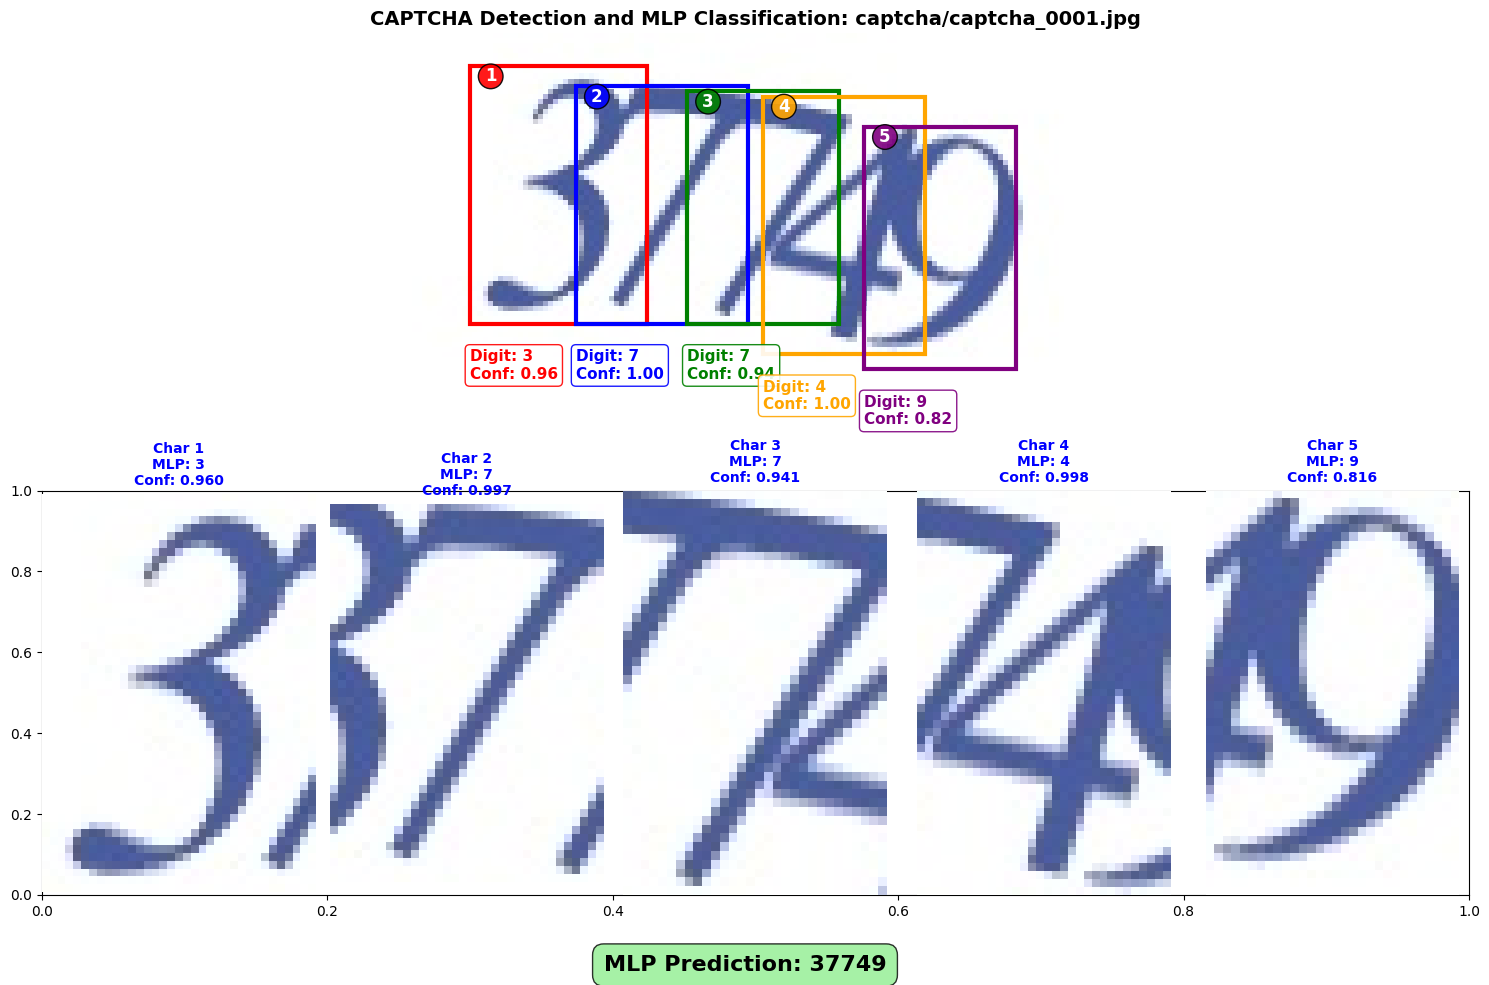


Detailed Results:
------------------------------------------------------------
Char 1: MLP=3 | Conf=0.960 | pos=(43,6,78,57)
Char 2: MLP=7 | Conf=0.997 | pos=(64,10,98,57)
Char 3: MLP=7 | Conf=0.941 | pos=(86,11,116,57)
Char 4: MLP=4 | Conf=0.998 | pos=(101,12,133,63)
Char 5: MLP=9 | Conf=0.816 | pos=(121,18,151,66)

Final CAPTCHA: 37749
------------------------------------------------------------

Processing: captcha/captcha_0002.jpg
Step 1: Detecting characters with YOLO...
YOLO output type: <class 'tuple'>
Number of scales: 5
Scale 0 shape: torch.Size([1, 8, 80, 200, 15])
Scale 1 shape: torch.Size([1, 8, 40, 100, 15])
Scale 2 shape: torch.Size([1, 8, 20, 50, 15])
Scale 3 shape: torch.Size([1, 8, 10, 25, 15])
Scale 4 shape: torch.Size([1, 8, 5, 12, 15])
Decoded boxes shape: torch.Size([5, 4])
Decoded scores shape: torch.Size([5])
Selected indices shape: torch.Size([5, 3])
Original size: (200, 80)
Target size: (200, 80)
Scale factors: x=1.000, y=1.000
Decoded box 0: (63.2, 15.6, 95.8

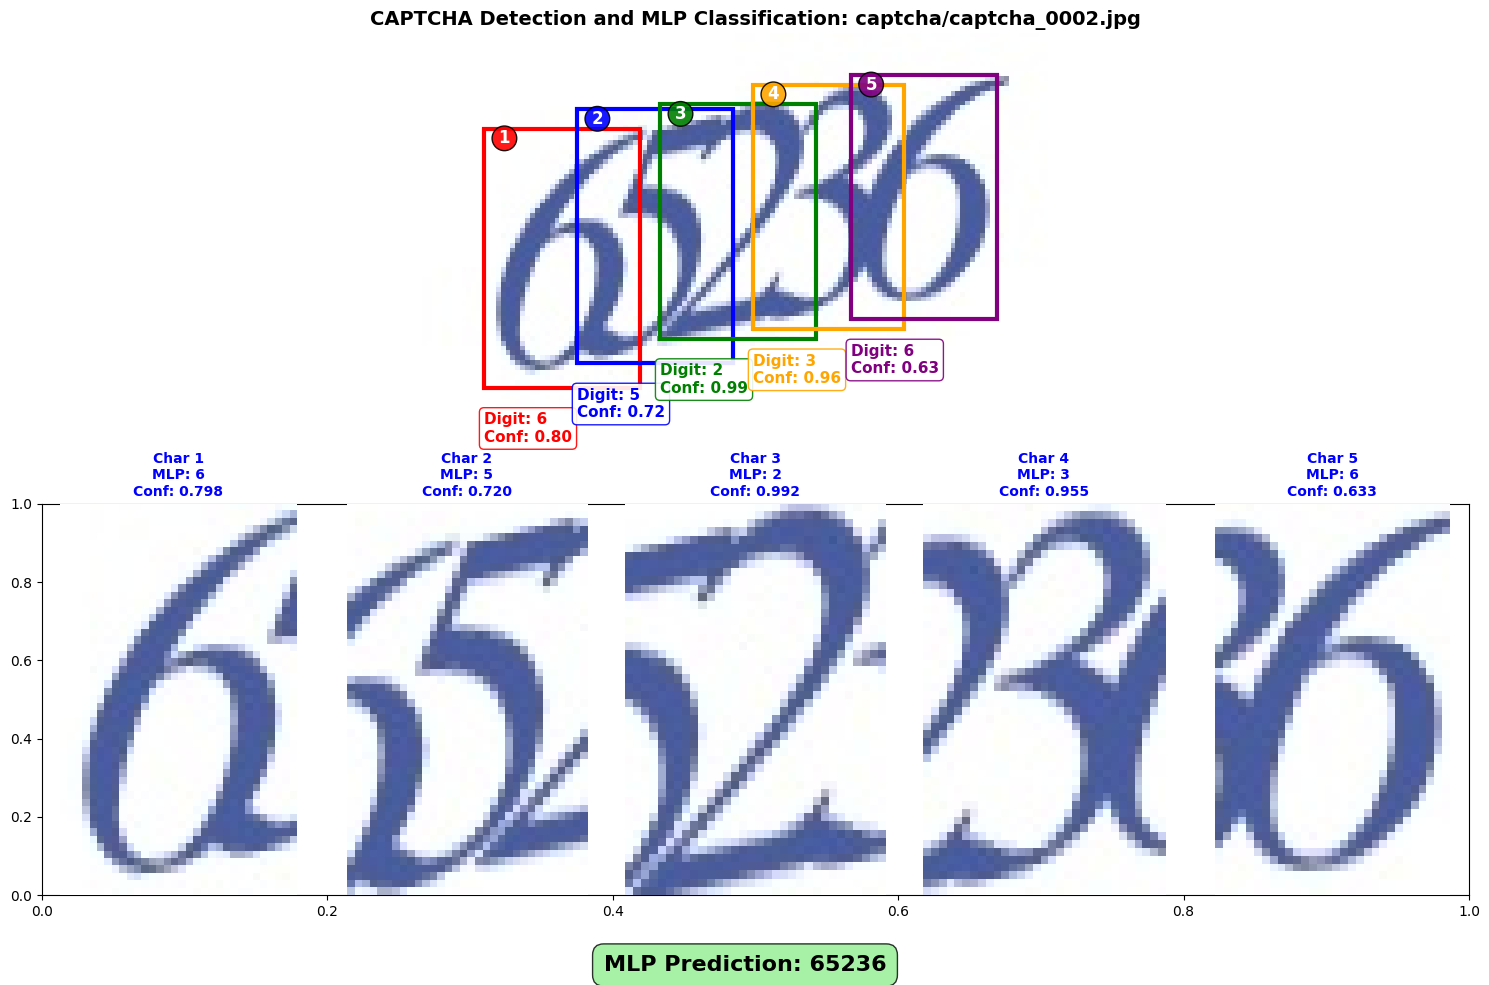


Detailed Results:
------------------------------------------------------------
Char 1: MLP=6 | Conf=0.798 | pos=(44,19,76,72)
Char 2: MLP=5 | Conf=0.720 | pos=(63,15,95,67)
Char 3: MLP=2 | Conf=0.992 | pos=(80,14,112,62)
Char 4: MLP=3 | Conf=0.955 | pos=(99,10,130,60)
Char 5: MLP=6 | Conf=0.633 | pos=(119,8,149,58)

Final CAPTCHA: 65236
------------------------------------------------------------

Processing: captcha/captcha_0003.jpg
Step 1: Detecting characters with YOLO...
YOLO output type: <class 'tuple'>
Number of scales: 5
Scale 0 shape: torch.Size([1, 8, 80, 200, 15])
Scale 1 shape: torch.Size([1, 8, 40, 100, 15])
Scale 2 shape: torch.Size([1, 8, 20, 50, 15])
Scale 3 shape: torch.Size([1, 8, 10, 25, 15])
Scale 4 shape: torch.Size([1, 8, 5, 12, 15])
Decoded boxes shape: torch.Size([5, 4])
Decoded scores shape: torch.Size([5])
Selected indices shape: torch.Size([5, 3])
Original size: (200, 80)
Target size: (200, 80)
Scale factors: x=1.000, y=1.000
Decoded box 0: (37.9, 24.4, 70.3,

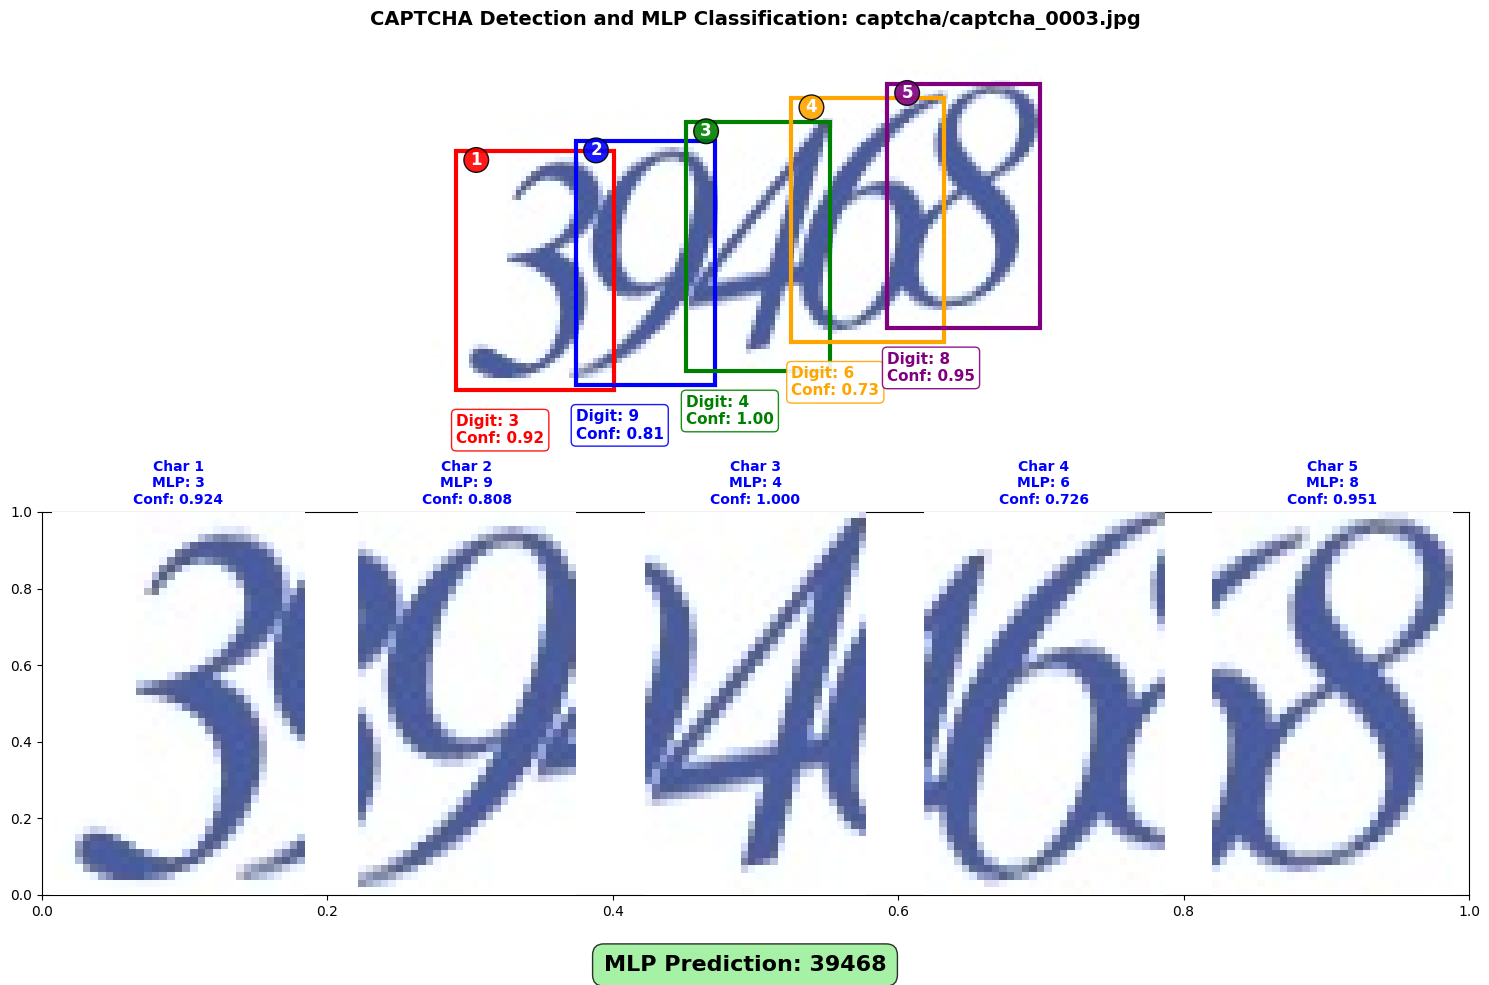


Detailed Results:
------------------------------------------------------------
Char 1: MLP=3 | Conf=0.924 | pos=(37,24,70,74)
Char 2: MLP=9 | Conf=0.808 | pos=(62,22,91,73)
Char 3: MLP=4 | Conf=1.000 | pos=(85,18,115,70)
Char 4: MLP=6 | Conf=0.726 | pos=(107,13,139,64)
Char 5: MLP=8 | Conf=0.951 | pos=(127,10,159,61)

Final CAPTCHA: 39468
------------------------------------------------------------

Processing: captcha/captcha_0018.jpg
Step 1: Detecting characters with YOLO...
YOLO output type: <class 'tuple'>
Number of scales: 5
Scale 0 shape: torch.Size([1, 8, 80, 200, 15])
Scale 1 shape: torch.Size([1, 8, 40, 100, 15])
Scale 2 shape: torch.Size([1, 8, 20, 50, 15])
Scale 3 shape: torch.Size([1, 8, 10, 25, 15])
Scale 4 shape: torch.Size([1, 8, 5, 12, 15])
Decoded boxes shape: torch.Size([5, 4])
Decoded scores shape: torch.Size([5])
Selected indices shape: torch.Size([5, 3])
Original size: (200, 80)
Target size: (200, 80)
Scale factors: x=1.000, y=1.000
Decoded box 0: (59.3, 6.1, 94.7

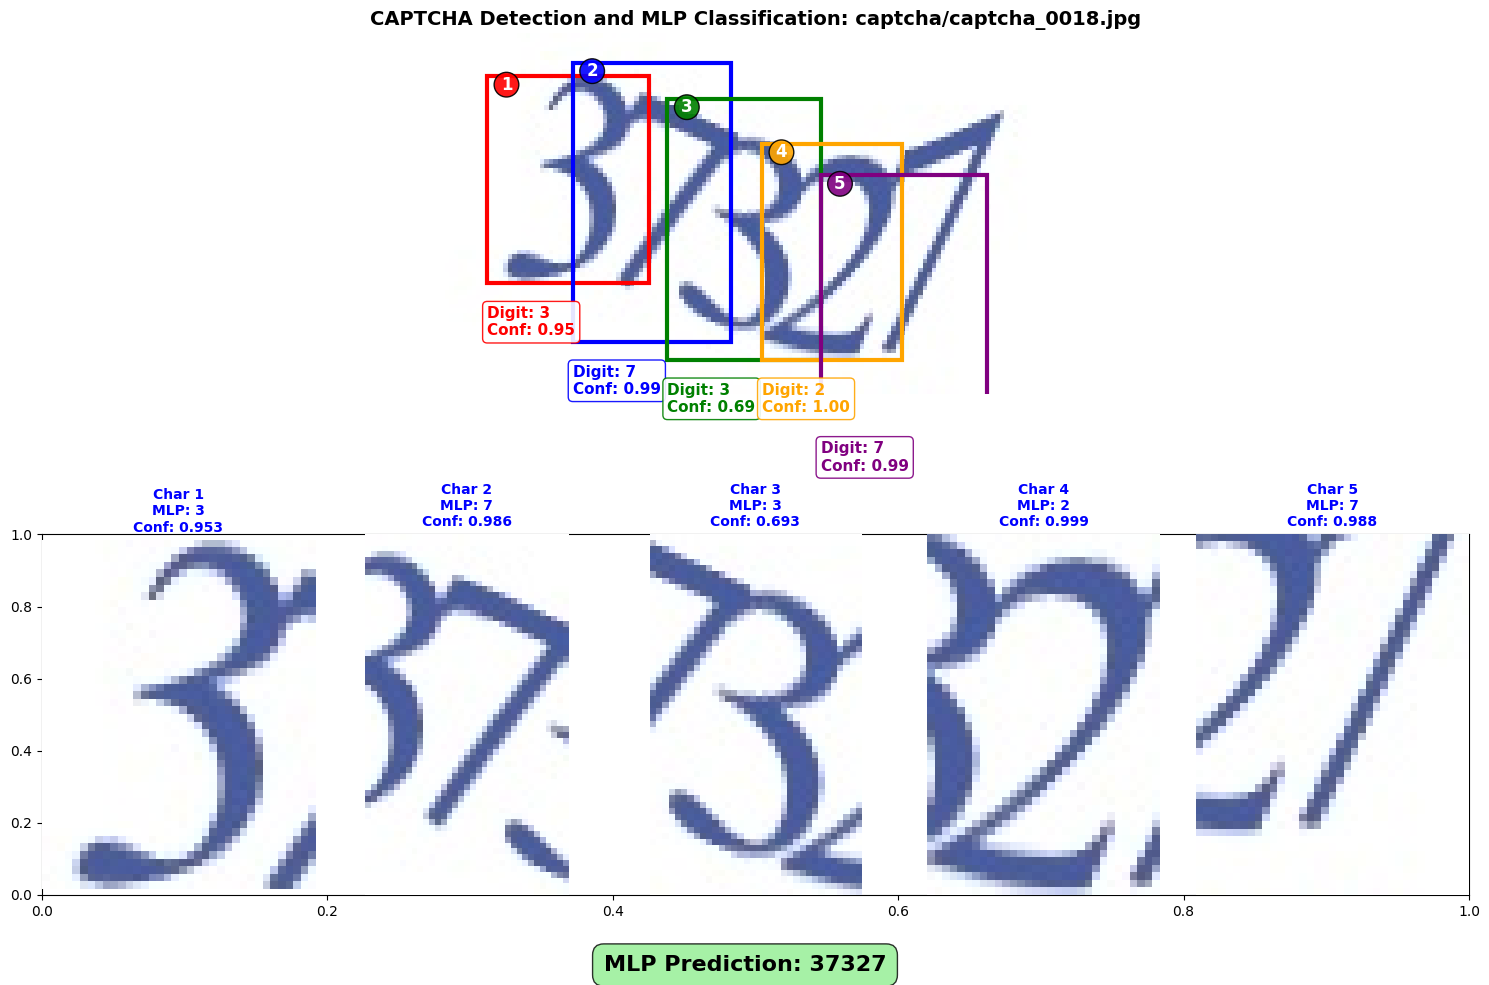


Detailed Results:
------------------------------------------------------------
Char 1: MLP=3 | Conf=0.953 | pos=(40,9,76,55)
Char 2: MLP=7 | Conf=0.986 | pos=(59,6,94,68)
Char 3: MLP=3 | Conf=0.693 | pos=(80,14,114,72)
Char 4: MLP=2 | Conf=0.999 | pos=(101,24,132,72)
Char 5: MLP=7 | Conf=0.988 | pos=(114,31,151,85)

Final CAPTCHA: 37327
------------------------------------------------------------

Processing: captcha/captcha_0019.jpg
Step 1: Detecting characters with YOLO...
YOLO output type: <class 'tuple'>
Number of scales: 5
Scale 0 shape: torch.Size([1, 8, 80, 200, 15])
Scale 1 shape: torch.Size([1, 8, 40, 100, 15])
Scale 2 shape: torch.Size([1, 8, 20, 50, 15])
Scale 3 shape: torch.Size([1, 8, 10, 25, 15])
Scale 4 shape: torch.Size([1, 8, 5, 12, 15])
Decoded boxes shape: torch.Size([5, 4])
Decoded scores shape: torch.Size([5])
Selected indices shape: torch.Size([5, 3])
Original size: (200, 80)
Target size: (200, 80)
Scale factors: x=1.000, y=1.000
Decoded box 0: (122.5, 22.2, 154.

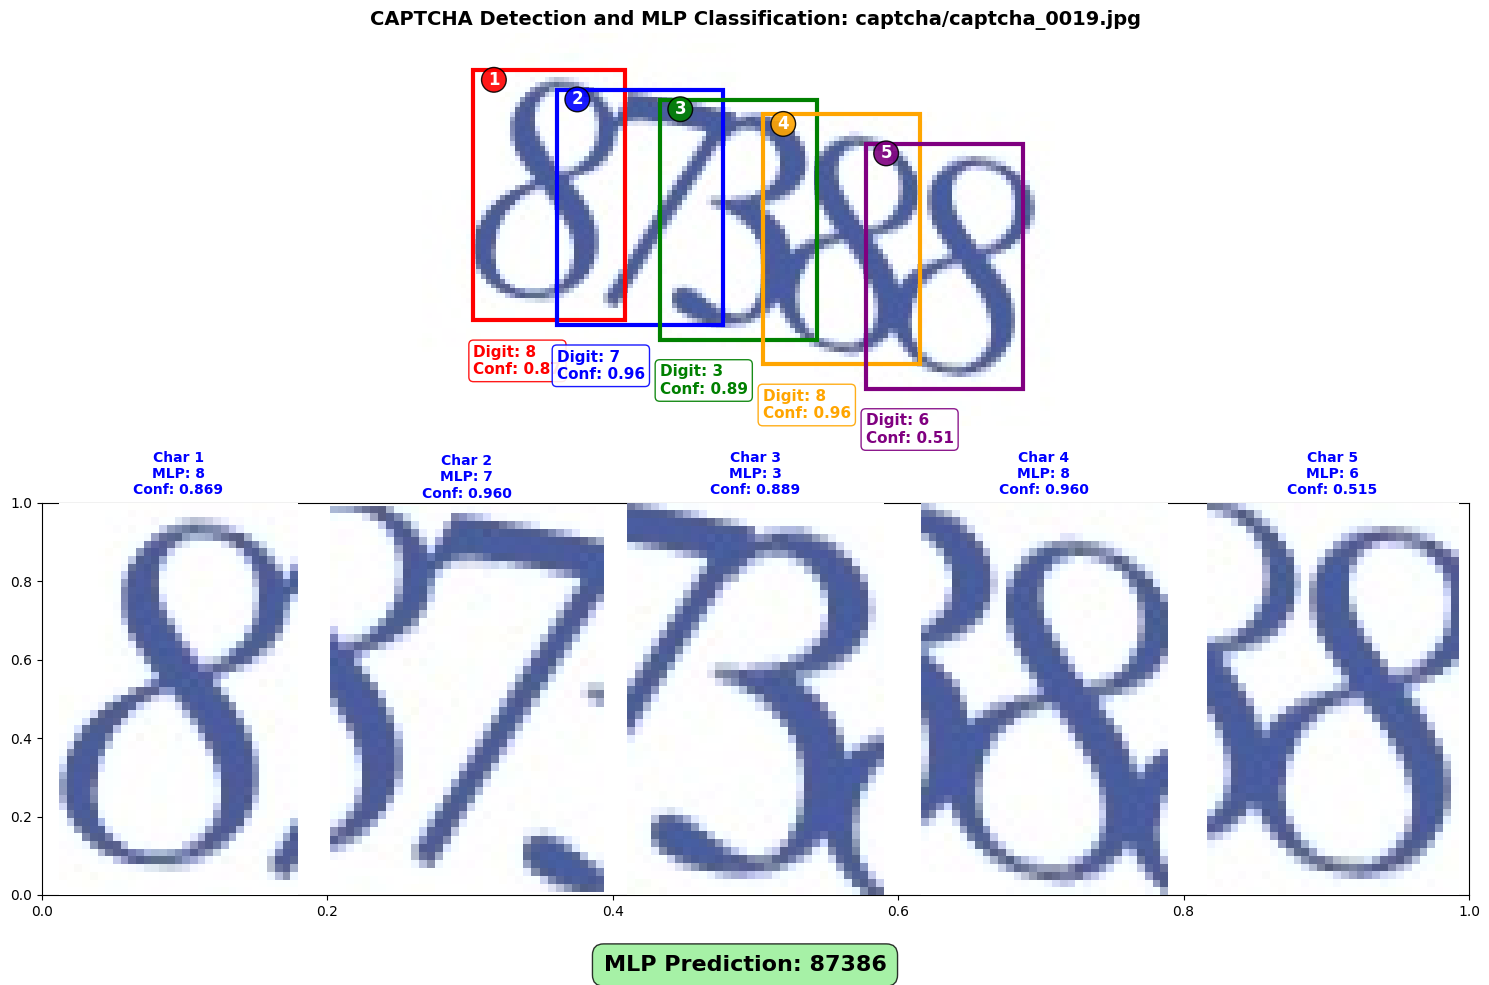


Detailed Results:
------------------------------------------------------------
Char 1: MLP=8 | Conf=0.869 | pos=(42,7,73,58)
Char 2: MLP=7 | Conf=0.960 | pos=(59,11,93,59)
Char 3: MLP=3 | Conf=0.889 | pos=(80,13,112,62)
Char 4: MLP=8 | Conf=0.960 | pos=(101,16,133,67)
Char 5: MLP=6 | Conf=0.515 | pos=(122,22,154,72)

Final CAPTCHA: 87386
------------------------------------------------------------


In [ ]:
# Updated main section with visualization
if __name__ == "__main__":
    # Load models
    print("Loading models...")
    yolo_model, classifier_model = load_models()
    
    # Test on multiple images with visualization
    test_images = [
        "img/captcha_0001.jpg",
        
    ]
    
    for image_path in test_images:
        print(f"\n{'='*80}")
        print(f"Processing: {image_path}")
        print('='*80)
        
        try:
            result = visualize_captcha_result(
                image_path, 
                yolo_model, 
                classifier_model, 
                conf_threshold=0.4,
                iou_threshold=0.3
            )
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            import traceback
            traceback.print_exc()

In [63]:
import os
from PIL import Image, ImageDraw
import torch
from torchvision import transforms

def inference_single_image_corrected(model, image_path, anchors, conf_thresh=0.45, iou_thresh=0.35, OUTPUT_DIR=None):
    """
    Run YOLO inference on a single image - corrected to match yolo.ipynb exactly
    """
    print(f"Running inference on single image: {image_path}")
    
    # Configuration - match yolo.ipynb exactly
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    IMG_SIZE = (80, 200)  # (H, W) as used in yolo.ipynb
    
    # Move model to device
    model = model.to(DEVICE)
    model.eval()
    
    # Create output directory if specified
    if OUTPUT_DIR:
        os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Define transform - EXACTLY as in yolo.ipynb
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),  # (H, W) = (80, 200)
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) 
    ])
    
    # Load and preprocess image
    try:
        img_pil = Image.open(image_path).convert("RGB")
        orig_w, orig_h = img_pil.size
        print(f"Original image size: {orig_w}x{orig_h}")
        
        # Apply transforms
        img_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)
        print(f"Input tensor shape: {img_tensor.shape}")
        
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return ""
    
    # Run inference
    with torch.no_grad():
        outputs = model(img_tensor)
        
        # Print output info for debugging
        if isinstance(outputs, (tuple, list)):
            print(f"Multi-scale outputs: {len(outputs)} scales")
            for i, out in enumerate(outputs):
                print(f"Scale {i}: {out.shape}")
        else:
            print(f"Single output shape: {outputs.shape}")
        
        # Decode predictions - use (W, H) format for decode_predictions
        decoded_results = decode_predictions(
            outputs, (200, 80), anchors,  # (W, H) format
            conf_thresh=conf_thresh,
            iou_thresh=iou_thresh
        )
        
        # Check if any detections
        if not decoded_results or len(decoded_results) == 0:
            print("No detections found!")
            return ""
        
        boxes, scores, sel_idx = decoded_results[0]

        # Debug if empty
        if boxes.numel() == 0:
            if isinstance(outputs, (tuple, list)):
                max_obj = max(output[...,0].sigmoid().max().item() for output in outputs)
                print(f"No boxes detected; max objectness: {max_obj:.3f}")
            else:
                print(f"No boxes detected; max objectness: {outputs[...,0].sigmoid().max().item():.3f}")
            return ""

        print(f"Found {len(boxes)} detections after NMS")

        # Get predicted classes - CORRECTED indexing
        pred_classes = []
        if isinstance(outputs, (tuple, list)):
            # Multi-scale: use first scale (highest resolution)
            cls_output = outputs[0]  # Shape: [1, A, H, W, 5+num_classes]
            cls_logits = cls_output[0, ..., 5:]  # Shape: [A, H, W, num_classes]
            
            for idx in sel_idx:
                a, y, x = idx.tolist()
                # Ensure indices are within bounds
                A, H, W, C = cls_logits.shape
                a = min(a, A-1)
                y = min(y, H-1)
                x = min(x, W-1)
                
                class_prob = cls_logits[a, y, x].softmax(dim=-1)
                pred_class = class_prob.argmax().item()
                pred_classes.append(pred_class)
        else:
            # Single scale
            cls_logits = outputs[0, ..., 5:]  # [A, H, W, num_classes]
            for idx in sel_idx:
                a, y, x = idx.tolist()
                A, H, W, C = cls_logits.shape
                a = min(a, A-1)
                y = min(y, H-1)
                x = min(x, W-1)
                
                class_prob = cls_logits[a, y, x].softmax(dim=-1)
                pred_class = class_prob.argmax().item()
                pred_classes.append(pred_class)

        # Sort boxes and classes by x1 (left coordinate)
        boxes_np = boxes.cpu().numpy()
        sort_idx = boxes_np[:, 0].argsort()
        boxes_sorted = boxes_np[sort_idx]
        pred_classes_sorted = [pred_classes[i] for i in sort_idx]
        scores_sorted = [scores[i].item() for i in sort_idx]

        # Print detailed results
        print("\nDetection Results:")
        print("-" * 70)
        for i, (box, cls, score) in enumerate(zip(boxes_sorted, pred_classes_sorted, scores_sorted)):
            x1, y1, x2, y2 = box
            print(f"Char {i+1}: digit={cls}, conf={score:.3f}, box=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")

        # Draw boxes and save if specified
        if OUTPUT_DIR:
            draw = ImageDraw.Draw(img_pil)
            
            # Scale factors - boxes are in (200, 80) coordinates
            scale_x = orig_w / 200
            scale_y = orig_h / 80
            
            for i, (x1, y1, x2, y2) in enumerate(boxes_sorted):
                # Scale to original image size
                x1_orig = x1 * scale_x
                y1_orig = y1 * scale_y
                x2_orig = x2 * scale_x
                y2_orig = y2 * scale_y
                
                # Draw bounding box
                draw.rectangle([x1_orig, y1_orig, x2_orig, y2_orig],
                             outline="red", width=3)
                
                # Add la
            
            # Save annotated image
            output_path = os.path.join(OUTPUT_DIR, os.path.basename(image_path))
            img_pil.save(output_path)
            print(f"Annotated image saved to: {output_path}")

        # Build final prediction
        predicted_captcha = ''.join(str(c) for c in pred_classes_sorted)
        
        print("-" * 70)
        print(f"Final CAPTCHA Prediction: {predicted_captcha}")
        print("-" * 70)
        
        return predicted_captcha

# Updated usage that exactly matches your yolo.ipynb workflow
if __name__ == "__main__":
    # Load model
    yolo_model, _ = load_models()
    
    # Test image
    image_path = r"img\0_68387.png"
    
    try:
        result = inference_single_image_corrected(
            model=yolo_model,
            image_path=image_path,
            anchors=anchors,
            conf_thresh=0.45,
            iou_thresh=0.35,
            OUTPUT_DIR="inference_output"
        )
        
        print(f"\n🎯 FINAL RESULT: {result}")
        
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()

Loaded classifier with validation accuracy: 99.00%
Running inference on single image: img\0_68387.png
Original image size: 200x80
Input tensor shape: torch.Size([1, 1, 80, 200])
Multi-scale outputs: 5 scales
Scale 0: torch.Size([1, 8, 80, 200, 15])
Scale 1: torch.Size([1, 8, 40, 100, 15])
Scale 2: torch.Size([1, 8, 20, 50, 15])
Scale 3: torch.Size([1, 8, 10, 25, 15])
Scale 4: torch.Size([1, 8, 5, 12, 15])
Found 5 detections after NMS

Detection Results:
----------------------------------------------------------------------
Char 1: digit=3, conf=1.000, box=(41.1,-0.0,76.2,61.9)
Char 2: digit=5, conf=1.000, box=(62.8,7.8,97.3,68.5)
Char 3: digit=6, conf=0.997, box=(83.0,15.6,117.4,70.8)
Char 4: digit=6, conf=1.000, box=(102.9,17.2,137.4,72.3)
Char 5: digit=5, conf=1.000, box=(122.5,12.5,159.6,68.1)
Annotated image saved to: inference_output\0_68387.png
----------------------------------------------------------------------
Final CAPTCHA Prediction: 35665
----------------------------------